## Imports and Config

In [1]:
import psycopg2
from pytz import timezone
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mpl_dates
import matplotlib.ticker as ticker

import os
from pathlib import Path
from configparser import ConfigParser

conf = ConfigParser()
conf.read(Path(os.getcwd()) / 'logging_config.ini')
local_timezone = timezone(conf['logging'].get('local_timezone', 'UTC'))

conn = psycopg2.connect(
    host=conf['postgres'].get('hostname'),
    database=conf['postgres'].get('database'),
    port=conf['postgres'].get('port', 5432),
    user=conf['postgres'].get('username'),
    password=conf['postgres'].get('password')
)
cur = conn.cursor()

## Fetch the most recent data

In [2]:
df = pd.read_sql(
    """
    select *, temp_avg*1.8+32 as temp_avg_f
    from env_log
    %s
    """ % ("where ts_load_utc >= current_timestamp - interval '48 hours'" if False else ""),
    conn
)
df.ts_load_utc = df.ts_load_utc.dt.tz_localize(timezone('UTC'))
df['ts_local'] = df.ts_load_utc.dt.tz_convert(local_timezone)

## Assemble the Chart

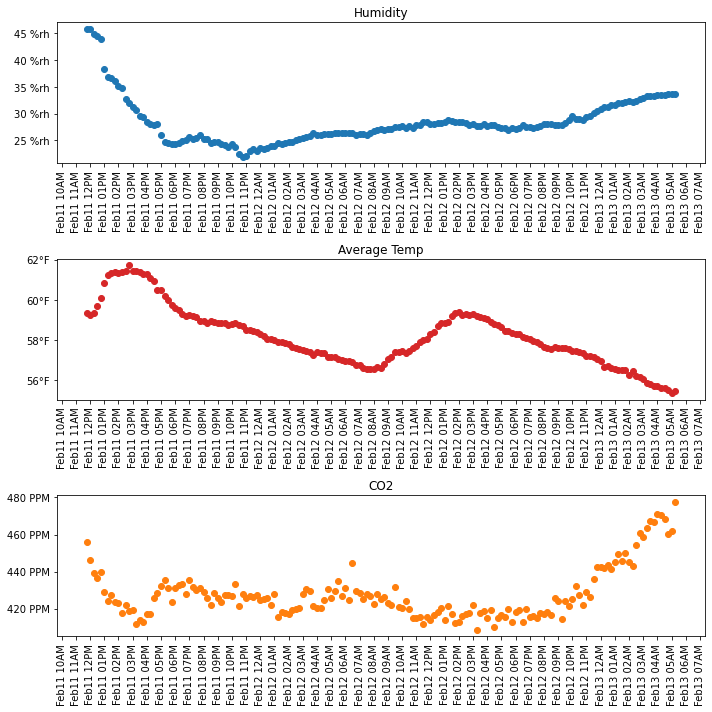

In [3]:
gs = gridspec.GridSpec(3, 1)
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(10,10))
(ax1, ax2, ax3) = [fig.add_subplot(gs[loc[0], loc[1]]) for loc in [[0,0],[1,0],[2,0]]]
for ax, column, title, color, append, locator_multiple in zip(
    (ax1, ax2, ax3), 
    ('humidity', 'temp_avg_f', 'co2'),
    ('Humidity', 'Average Temp', 'CO2'),
    ('tab:blue', 'tab:red', 'tab:orange'),
    (' %rh', '°F', ' PPM'),
    (5, 2, 20)
):
    ax.xaxis.set_major_locator(mpl_dates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%b%d %I%p', tz=timezone('America/Los_Angeles'))) 

    ax.set_title(title)

    ax.scatter(
        df.ts_local,
        df[column],
        color=color
    )

    ax.yaxis.set_major_locator(ticker.MultipleLocator(locator_multiple))
    ax.yaxis.set_major_formatter('{x:1.0f}%s'%append)
    ax.tick_params(axis='x', labelrotation=90)

fig.set_facecolor('white')

In [ ]:
fig.savefig(
    Path(os.getcwd()) / 'env_log_plot.png',
    dpi=300,
    backend='agg',
    metadata={
        'Title': 'Env Logs: %s' % df.loc[0, 'location'],
        'Description': 'Humidity, Temperature, and CO2 for %s' % df.loc[0, 'location'],
        'Software': 'matplotlib'
    }
)